In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [6]:
excel_file = 'BTC-HIS-TRAIN.xlsx'
data = pd.read_excel(excel_file)
(data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


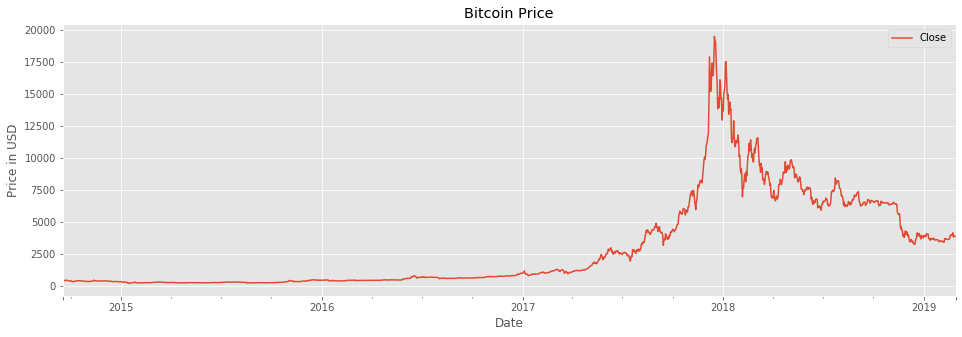

In [7]:
data.plot(x = 'Date',y = 'Close',figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

In [8]:
data = data.set_index("Date")[['Close']]
data = data.set_index(pd.to_datetime(data.index))

In [9]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
data.head()

,Close
Date,
2014-09-17,0.014453
2014-09-18,0.012751
2014-09-19,0.011216
2014-09-20,0.011947
2014-09-21,0.011425


In [10]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


In [11]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(data.Close), n_per_in, n_per_out)



In [12]:
y.shape

(1587, 10)

In [13]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [14]:
X.shape

(1587, 30, 1)

In [15]:
X[0]

array([[0.01445348],
       [0.01275083],
       [0.0112164 ],
       [0.01194666],
       [0.01142474],
       [0.01159716],
       [0.01333837],
       [0.0126869 ],
       [0.01208486],
       [0.01171481],
       [0.01146092],
       [0.01030462],
       [0.0102159 ],
       [0.01080997],
       [0.01063765],
       [0.01019545],
       [0.00939004],
       [0.00780375],
       [0.00737123],
       [0.00786654],
       [0.0081827 ],
       [0.00904986],
       [0.00967546],
       [0.00949615],
       [0.0095343 ],
       [0.01037543],
       [0.01098958],
       [0.0115308 ],
       [0.01121521],
       [0.01058284]])

In [16]:
y[0]

array([0.01064506, 0.01104279, 0.01094465, 0.0105978 , 0.01078569,
       0.010614  , 0.00933336, 0.00932964, 0.00875643, 0.00914117])

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
model = Sequential()

In [19]:
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],1)))
model.add(Dropout(0.5))
model.add(LSTM(units=12, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=12, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units = 10, activation = 'softsign'))
model.add(Dropout(0.5))
model.add(Dense(units=10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)               

In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
res = model.fit(X, y, epochs=120, batch_size=32,validation_split=0.2)

Train on 1269 samples, validate on 318 samples
Epoch 1/120
1269/1269 [==============================] - 5s 4ms/step - loss: 0.0356 - val_loss: 0.0211
Epoch 2/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0216 - val_loss: 0.0074
Epoch 3/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0163 - val_loss: 0.0050
Epoch 4/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0144 - val_loss: 0.0035
Epoch 5/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0048
Epoch 6/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0111 - val_loss: 0.0025
Epoch 7/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 8/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0095 - val_loss: 0.0030
Epoch 9/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 10/120
1269/1269 [==

1269/1269 [==============================] - 3s 2ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 80/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 81/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 82/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 83/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 84/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 85/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 86/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 87/120
1269/1269 [==============================] - 3s 2ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 88/120
1269/1269 [==============================] - 3s 2ms/step - loss:

In [22]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    

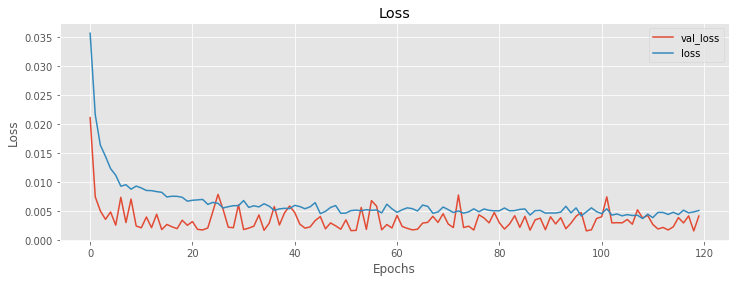

In [23]:
visualize_training_results(res)

In [24]:
excel_file1 = 'BTC-HIS-TEST.xlsx'
data_test = pd.read_excel(excel_file1)
(data_test.head(12))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786075
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175787
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126414
5,2019-03-06,3897.081055,3919.510498,3871.460693,3903.942627,3903.942627,9175291528
6,2019-03-07,3903.384766,3939.373291,3894.113037,3911.484375,3911.484375,9584165518
7,2019-03-08,3913.225830,3950.432129,3875.228516,3901.131592,3901.131592,10638638944
8,2019-03-09,3894.552490,3987.237793,3892.390381,3963.313721,3963.313721,10796103518
9,2019-03-10,3966.174316,3966.174316,3924.381104,3951.599854,3951.599854,9713267606


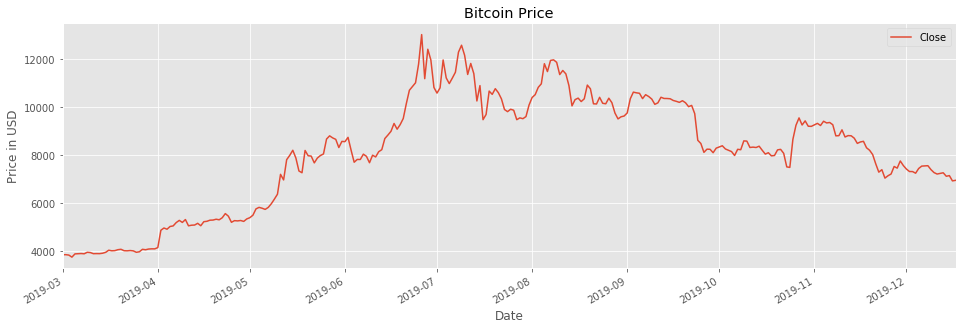

In [25]:
data_test.plot(x = 'Date',y = 'Close',figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

In [26]:
data_test = data_test.set_index("Date")[['Close']]
data_test = data_test.set_index(pd.to_datetime(data_test.index))

In [27]:
data_test = pd.DataFrame(scaler.fit_transform(data_test), columns=data_test.columns, index=data_test.index)

In [28]:
data_test.head()

,Close
Date,
2019-03-01,0.010592
2019-03-02,0.011114
2019-03-03,0.009251
2019-03-04,0.000000
2019-03-05,0.014568


In [29]:
data_test.shape

(351, 1)

In [30]:
def split_test_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X_test, y_test = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x_test, seq_y_test = seq[i:end], seq[end:out_end]
        
        X_test.append(seq_x_test)
        y_test.append(seq_y_test)
    
    return np.array(X_test), np.array(y_test)

In [31]:
X_test, y_test = split_test_sequence(list(data_test.Close), 30, 10)

In [43]:
X_test[-1]

array([0.54494881, 0.545889  , 0.57203193, 0.53986027, 0.54611376,
       0.54531423, 0.53449073, 0.51114009, 0.51749024, 0.5204309 ,
       0.49139806, 0.48025335, 0.46092502, 0.41937649, 0.38197136,
       0.39290845, 0.3551027 , 0.36571537, 0.37352087, 0.40737322,
       0.39996533, 0.43218015, 0.41147561, 0.39577139, 0.38471707,
       0.38451795, 0.37715833, 0.39836631, 0.40903   , 0.41002855])

In [33]:
y_test.shape

(312, 10)

In [34]:
yhat = model.predict(X_test[-1].reshape(1, 30, 1)).tolist()[0]

In [35]:
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

In [45]:
actual = scaler.inverse_transform(y_test[-1].reshape(-1,1))

Predicted Prices:
 [[7474.703710422277], [7480.419888994428], [7477.9930298747], [7488.817224232436], [7497.4205901287505], [7501.612638288852], [7501.978087582368], [7499.786495064427], [7497.54608403709], [7500.308329074488]]

Actual Prices:
 [[7564.345215], [7400.899414000001], [7278.119629], [7217.427246], [7243.134277], [7269.68457], [7124.673828], [7152.3017580000005], [6932.480469], [6954.864258]]


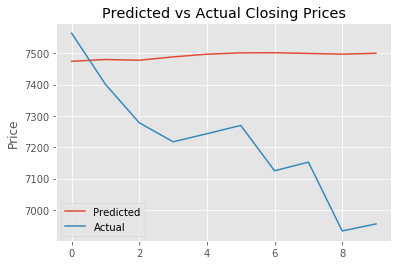

In [46]:
# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

In [41]:

yhat = model.predict(np.array(data_test.tail(30)).reshape(1, 30, 1)).tolist()[0]

yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=data_test.index[-1], periods=len(yhat), freq="D"), columns=data_test.columns)

# Printing the predicted prices
print(preds)


                  Close
2019-12-17  7474.703710
2019-12-18  7480.419889
2019-12-19  7477.993030
2019-12-20  7488.817224
2019-12-21  7497.420590
2019-12-22  7501.612638
2019-12-23  7501.978088
2019-12-24  7499.786495
2019-12-25  7497.546084
2019-12-26  7500.308329


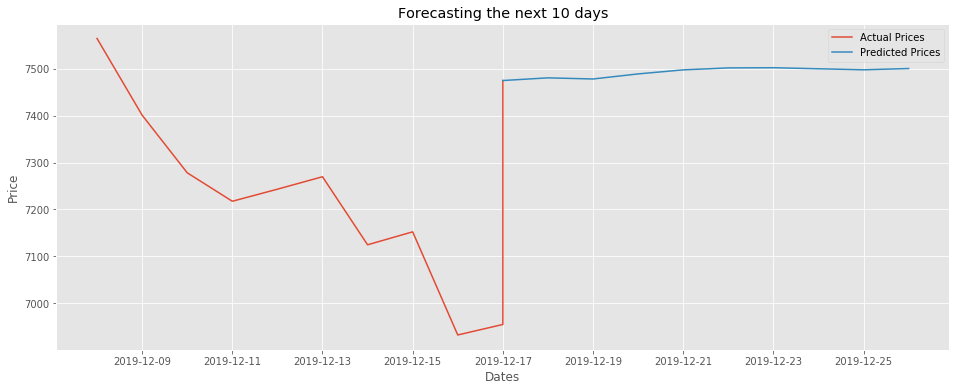

In [42]:
# Transforming the actual values to their original price
pers = 10

actual = pd.DataFrame(scaler.inverse_transform(data_test[["Close"]].tail(pers)), index=data_test.Close.tail(pers).index, columns=data_test.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()